# Reproduce Figures
1. Coverage vs. Atypicality Quantile, for any experimental setting
2. Coefficients $\beta$ for 3x3 Experimental Settings Using Atypicality 
3. Mean Coverage, Mean $\beta$, and Mean MSE from the Mean for values of $\lambda$
4. Coverage vs. Beta for values of $\lambda$


In [62]:
import sys
sys.path.append("../src")

from atypicality import compute_atypicality_scores
from data_generation_settings import split_and_scale_data, generate_and_split_mvn_data, generate_and_split_lognormal_data, generate_and_split_gmm_data, load_and_split_hf_data, load_and_split_support_data
from fit_cp_models import fit_rf_cp_model, fit_gaussian_cp_model, fit_conformal_cp_model
from compute_bounds import evaluate_lambda_adjusted_interval_coverage
from compute_betas import compute_beta
from lambda_tuning import lambda_hyperparameter_tuning, run_lambda_selection_and_evaluation
from plotting import plot_coverage_across_atypicality_quantile, plot_betagrouped_by_atypicality, plot_lambda_metrics

# 1. Calculating Coverage vs. Atypicality Quantile for any experimental setting
Generate a plot of coverage across atypicality quantile. The `evaluate_lambda_adjusted_interval_coverage` function creates a dataframe with coverage for each quantile and specified experimental settings. The `plot_coverage_across_atypicality_quantile` filters the dataframe by specified `atypicality_score` and plots coverage across quantiles for different $\lambda$ values. 

* In `atypicality_settings`, specify which atypicality scores to use: `knn_score`, `kde_score`, `logjointmvn_score`, `lognormal_score`, and `gmm_score`. For each score, specify a corresponding $\lambda$ value by which to adjust the bounds. Recall that the `lognormal_score` assumes positive target y; make sure to only use the `lognormal_score` in the `generate_and_split_lognormal_data` data gneration setting or else the function will return an error.
* Specify which data generation setting to use: `generate_and_split_mvn_data`, `generate_and_split_lognormal_data`, and `generate_and_split_gmm_data`.
* Specify which conformal prediction algorithm to use: `fit_rf_cp_model`, `fit_gaussian_cp_model`, `fit_conformal_cp_model`
* When `true_atypicality=True`, we use the true atypicality value. When `true_atypicality=False`, we use the predicted atypicality value.
* When `return_df=True`, the second value of the returned tuple will contain predictions, lower and upper intervals generated by the CP algorithm, and adjusted intervals according to $\lambda$. 
* `silent` mutes print statements from the internal functions, reporting status. 

In our paper, we use `n_samples = 5000`, `n_splits=5`, and `num_quantiles = 5`. 

In [176]:
atypicality_settings = [
    ('logjointmvn_score', 0),
    # ('knn_score', 1)
]

# Run calibration across all atypicality types
coverage_by_quantile_lambda, df = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=generate_and_split_lognormal_data, 
                                        fit_cp_model=fit_gaussian_cp_model, 
                                        n_samples=5000,
                                        n_splits=5, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        silent=True)

# Peek at output: coverage across atypicality score, quantile, split, and lambda
coverage_by_quantile_lambda.head(5)

,score,lambda,quantile,coverage,split
0,logjointmvn_score,0,0,0.980,0
1,logjointmvn_score,0,1,0.985,0
2,logjointmvn_score,0,2,0.945,0
3,logjointmvn_score,0,3,0.790,0
4,logjointmvn_score,0,4,0.335,0


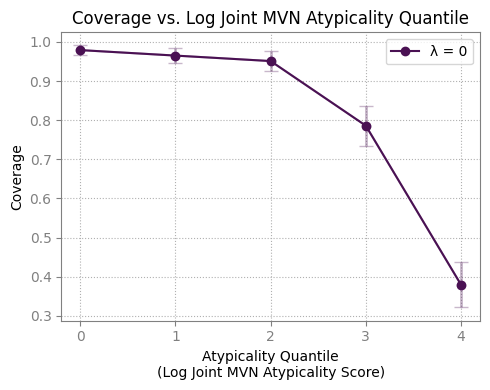

In [177]:
# Plot result for a specific atypicality score
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

# 2. Calculate $\beta$ for 3x3 Experimental Settings Using Atypicality
Our paper demonstreates the utility of atypicality by calculating the coefficient for coverage vs. atypicality quantile across several data generation settings, conformal prediction algorithms, and atypicality scores. The following code uses `compute_beta` to regenerate the figure, iterating across all experimental settings. 

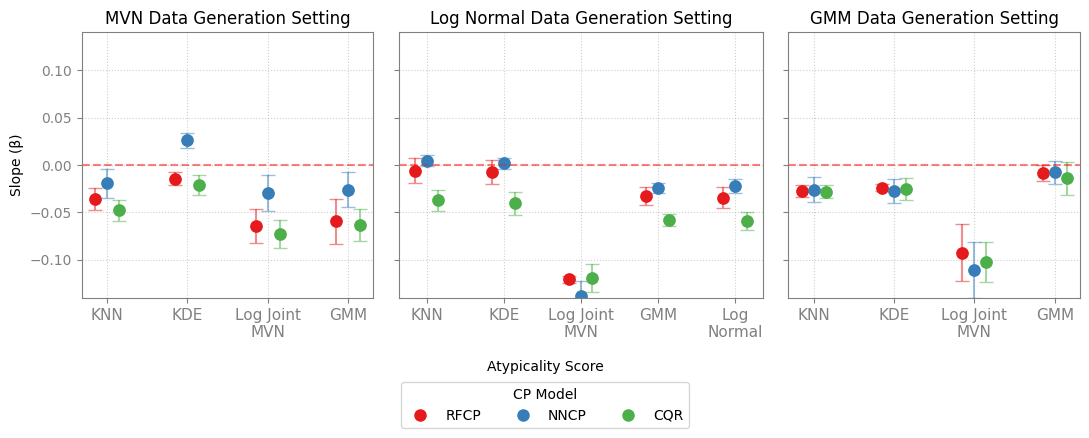

In [ ]:
# Takes 353min to run
beta_df = compute_beta(true_atypicality=True, silent=True)
beta_df.to_csv('../intermediate/3x3_trueatypicality.csv', index=False)
plot_betagrouped_by_atypicality(beta_df=beta_df, true_atypicality=True, outputfile="3x3_atypicality.png")

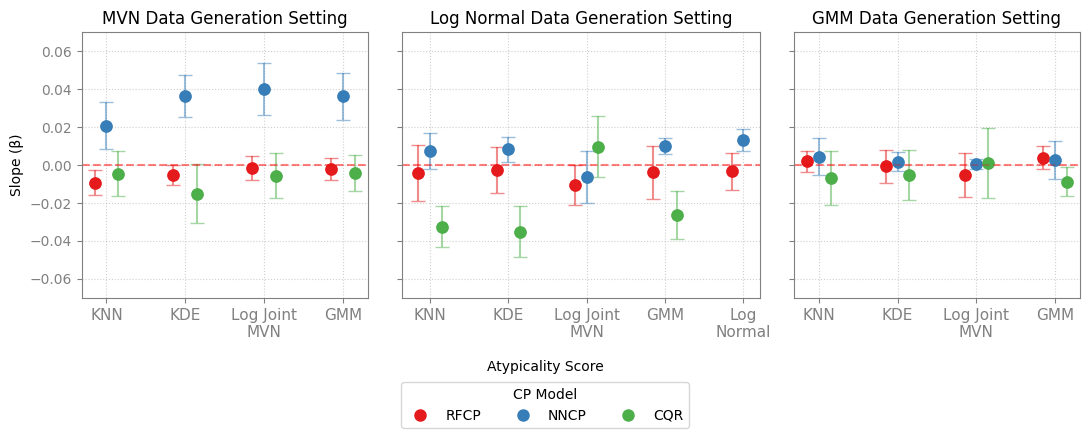

In [ ]:
# Takes 93 minutes to run
beta_df = compute_beta(true_atypicality=False, silent=True)
beta_df.to_csv('../intermediate/3x3_predictedatypicality.csv', index=False)
plot_betagrouped_by_atypicality(beta_df=beta_df, true_atypicality=False, outputfile="3x3_predicted_atypicality.png")

# 3 & 4. Performance metrics and Coverage vs. Beta for values of $\lambda$ 
* different metrics for different values of $\lambda$.
* Coverage vs. beta for different values of $\lambda$. 
* Distribution of relative position of points within the interval.

Things to check:
1. Calibration for $\lambda$ does not use data that was already used to train
2. Change graph to be more aesthetically appealing
3. Change graphs above as well to be more sighlty
4. do I want to allow users to specify how many steps of lambda are tested? how many n_samples? make the inputs into lambda_hyperparameter_tuning more similar to evaluate_...? 

For the specified atypicality score `atyp_col`, the function `lambda_hyperparameter_tuning` will calculate performance metrics on `y_test`. 
* When `hyperparamter_tuning=True`, the function treats `y_test` like a second calibration set to choose $\lambda$. If `hyperparamter_tuning=False`, then we generate entirely new data on which to calculate coverage for $\lambda$, using offset random seeds. This ensures no data leakage between hyperparameter tuning and evaluation.

It returns the following objects: 
* `lambda_metrics` is a dictionary, where each key refers to a $\lambda$ value and each value refers to a dataframe containing performance metrics
* `lambda_results` is a dataframe of point predictions and $\lambda$-adjusted bounds
* `merged_dfs` is a dictionary, where each key refers to a $\lambda$ value and each value refers to dataframe containing the coverage across atypicality quantile

In [270]:
lambda_metrics, lambda_results, merged_dfs = lambda_hyperparameter_tuning(atyp_col='logjointmvn_score', 
                                                            make_and_split_data=generate_and_split_mvn_data, 
                                                            fit_cp_model=fit_conformal_cp_model, 
                                                            n_splits=5, 
                                                            true_atypicality=True, 
                                                            hyperparameter_tuning=True)
plot_lambda_metrics(lambda_metrics)

KeyboardInterrupt: 

In the following code, we use the `lambda_hyperparameter_tuning` with `hyperparamter_tuning=True` to select the best $\lambda$ value. Then, we can evaluate coverage using the best $\lambda$ value on new data. 

In [ ]:
# Function to iterate through the atypicality scores, find the best lambda, and return relevant metrics. 
# atyp_scores = ['knn_score', 'kde_score', 'log_joint_mvn_score', 'gmm_score', 'lognormal_score']
# data_generation_settings = [generate_and_split_mvn_data, generate_and_split_lognormal_data, generate_and_split_gmm_data]
# cp_models = [fit_rf_cp_model, fit_gaussian_cp_model, fit_conformal_cp_model]

atyp_scores = ['knn_score', 'kde_score']
data_generation_settings = [generate_and_split_mvn_data]
cp_models = [fit_rf_cp_model, fit_conformal_cp_model]
true_atypicality = True
n_splits = 1

lambda_metric_results, coverage_results = run_lambda_selection_and_evaluation(atyp_scores, 
                                                                              data_generation_settings, 
                                                                              cp_models, 
                                                                              n_splits, 
                                                                              true_atypicality)

Lambda with highest overall coverage: knn_score_lam1-0 with coverage 0.8675
Lambda with coefficients closest to 0: knn_score_lam0-5 with coefficient value 0.005000000000000005
Lambda with lowest MSE: knn_score_lam0-5 with MSE 0.00024999999999999935
Lambda with highest overall coverage: knn_score_lam0-0 with coverage 0.8025
Lambda with coefficients closest to 0: knn_score_lam0-5 with coefficient value 0.02375000000000002
Lambda with lowest MSE: knn_score_lam0-5 with MSE 0.002562500000000001
Lambda with highest overall coverage: knn_score_lam0-75 with coverage 0.7975
Lambda with coefficients closest to 0: knn_score_lam0-75 with coefficient value 0.011250000000000008
Lambda with lowest MSE: knn_score_lam0-75 with MSE 0.0009624999999999984
Lambda with highest overall coverage: knn_score_lam0-75 with coverage 0.8299999999999998
Lambda with coefficients closest to 0: knn_score_lam0-75 with coefficient value 0.013749999999999998
Lambda with lowest MSE: knn_score_lam0-75 with MSE 0.00141249999

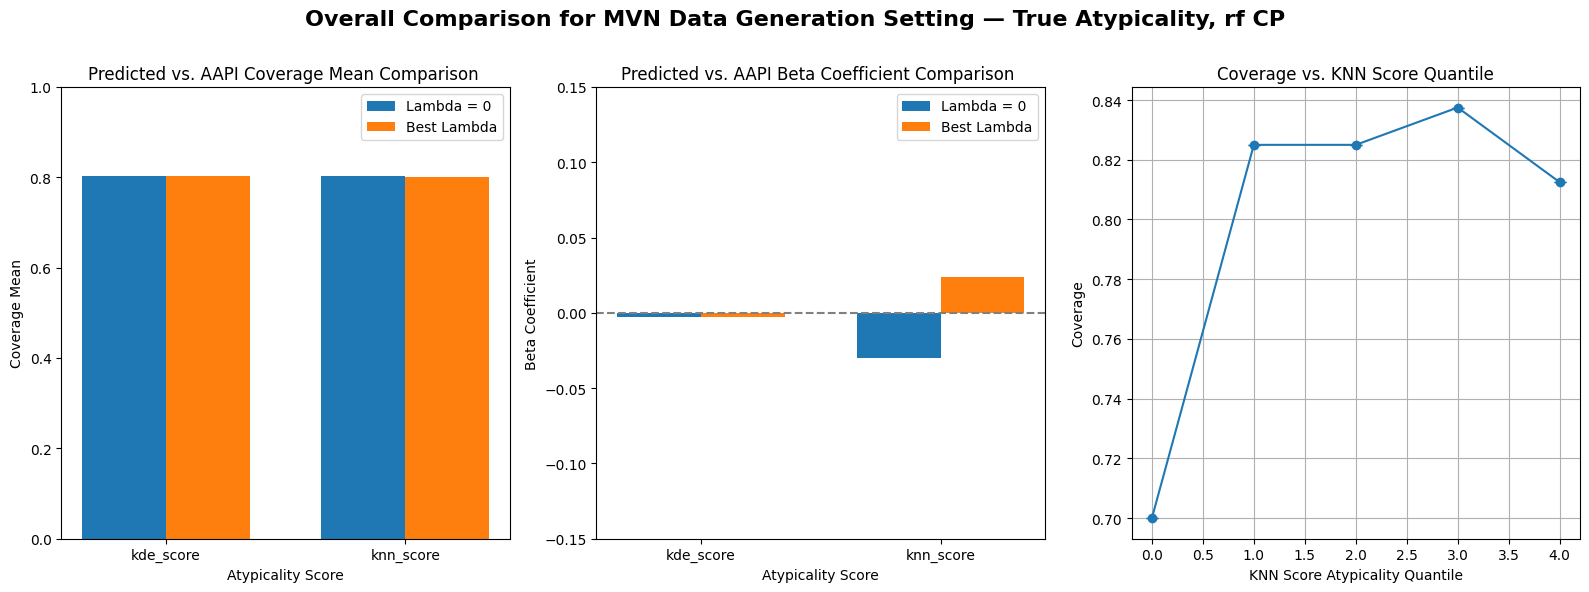

In [ ]:
# atyp_scores = ['knn_score']
# data_generation_settings = [generate_and_split_mvn_data]
# cp_models = [fit_rf_cp_model]

from plotting import plot_datagen_lambda_comparison

plot_datagen_lambda_comparison(lambda_metric_results, 
                               coverage_results,
                               atyp_col = 'knn_score',
                               atypicality_score_title = 'KNN Score',
                               data_generation_setting = generate_and_split_mvn_data,
                               data_generation_setting_title = 'MVN Data Generation Setting',
                               cp_model = fit_rf_cp_model,
                               atypicality_scores = ['knn_score', 'kde_score', 
                                                        'log_joint_mvn_score', 'lognormal_score',
                                                        'gmm_score'],
                               true_atypicality = True)

Next:
* change color of plots - use colab v4 to update the right-most plot of this graph with colors

# Generating Teaser Figure
3 sub-figures to show:
1. atypicality is correlated with lower coverage (beta is negative)
2. atypicality overlaps with underrepresented demographic groups
3. there are points that are in represented groups that are atypical and have low-coverage

- using SUPPORT2 data + logjointmvn score

First: check if SUPPORT2 is MVN.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
def load_and_split_support_numeric_data(random_seed, test_size=0.2, calib_size=0.2, n_samples=None):
    df_support2 = pd.read_csv('../data/support2.csv')

    # Drop if race or sfdm2 is na
    df_support2 = df_support2.dropna(subset=['race', 'sfdm2'])

    # Drop previous models' recommendations (suggested by data doc)
    leaky_vars_to_drop = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
    df_support2.drop(columns=leaky_vars_to_drop, inplace=True)
    
    # Drop rows with 1 missing value
    missing_counts = df_support2.isnull().sum()
    columns_with_one_missing = missing_counts[missing_counts == 1].index.tolist()
    rows_to_drop_indices = []

    for col in columns_with_one_missing:
        row_index = df_support2[df_support2[col].isnull()].index[0]
        rows_to_drop_indices.append(row_index)
    df_support2.drop(list(set(rows_to_drop_indices)), inplace=True)

    # Drop columns with more than 50% missingness
    drop_cols = ['adlp', 'urine', 'glucose']
    df_support2.drop(columns=drop_cols, inplace=True)

    # Impute the numeric columns
    num_cols = df_support2.select_dtypes(include='number').columns.tolist()
    num_imputer = SimpleImputer(strategy='median')
    df_support2[num_cols] = num_imputer.fit_transform(df_support2[num_cols])

    # Drop categorical columns except for race and sfdm2
    cols_to_drop = ['ca', 'dzgroup', 'dzclass', 'sex', 'income', 'hospdead', 'diabetes', 'dementia', 'race']
    df_support2.drop(columns=cols_to_drop, inplace=True)

    # Map ordinal sfdm2
    sfdm2_mapping = {
        'no(M2 and SIP pres)': 1,
        'adl>=4 (>=5 if sur)': 2,
        'SIP>=30': 3,
        'Coma or Intub': 4,
        '<2 mo. follow-up': 5}
    df_support2['sfdm2'] = df_support2['sfdm2'].map(sfdm2_mapping)

    # One-hot encode race
    # df_support2 = pd.get_dummies(df_support2, columns=['race'], drop_first=False, dtype=int)

    # Add missingness flags
    for col in df_support2.columns:
        df_support2[col + '_missing'] = df_support2[col].isnull().astype(int)

    # Drop rows with 6 or more missing values
    missing_flag_cols = [c for c in df_support2.columns if c.endswith('_missing')]
    df_support2['num_missing'] = df_support2[missing_flag_cols].sum(axis=1)
    df_support2 = df_support2[df_support2['num_missing'] <= 6].copy()

    # Recompute numeric columns AFTER all transformations
    num_cols = df_support2.select_dtypes(include='number').columns.tolist()

    # Drop _missing and helper columns
    num_cols = [c for c in num_cols if not c.endswith('_missing') and c != 'num_missing']
    assert 'sfdm2' in num_cols
    df_support2 = df_support2[num_cols].copy()

    # Log transform columns
    # cols_to_log = [
    # 'slos', 'd.time', 'num.co', 'scoma', 'charges', 'totcst', 'totmcst', 
    # 'avtisst', 'sps', 'aps', 'hday', 'wblc', 'hrt', 'resp', 'temp', 
    # 'alb', 'bili', 'crea', 'bun'
    # ]
    # cols_to_log = [c for c in cols_to_log if c in df_support2.columns]

    # # Shift if necessary to avoid log(0) or negatives
    # for col in cols_to_log:
    #     min_val = df_support2[col].min()
    #     if min_val <= 0:
    #         df_support2[col] = np.log1p(df_support2[col] - min_val + 1)  # shift to >0
    #     else:
    #         df_support2[col] = np.log(df_support2[col])

    # Temporary sample of dataset to make it smaller
    df_support2 = df_support2.sample(n=1000, random_state=random_seed)

    # Split data
    X, y = df_support2.drop(columns=['sfdm2']).to_numpy(), df_support2['sfdm2'].to_numpy()
    X_fit, X_calib, X_test, y_fit, y_calib, y_test, scaler = split_and_scale_data(X, y, test_size, calib_size, random_seed)

    return X_fit, X_calib, X_test, y_fit, y_calib, y_test, scaler

atypicality_settings = [
    ('logjointmvn_score', 0),
    # ('logjointmvn_score', 0.5)
]

coverage_by_quantile_lambda, df_support2 = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_support_numeric_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=500, # Number of samples is ignored; real dataset is of fixed size
                                        n_splits=2, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        silent=True)

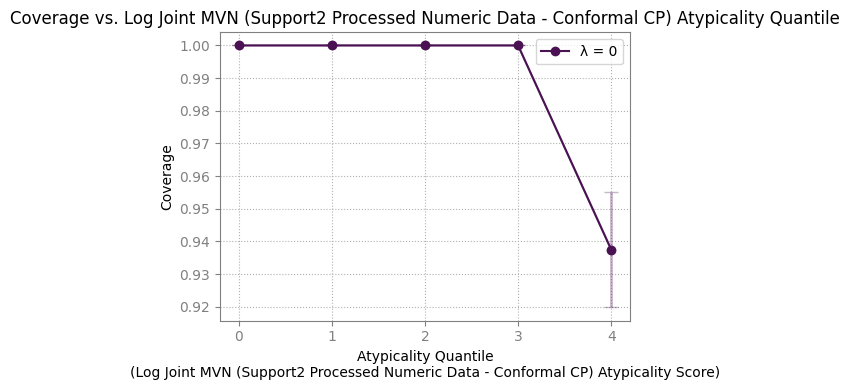

In [115]:
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN (Support2 Processed Numeric Data - Conformal CP)",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

# Calculating df with atypicality and race

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

def split_and_scale_data_race(X, y, test_size, calib_size, random_seed, extra_arrays=None):
    if extra_arrays is None:
        extra_arrays = []

    # First split: train / test
    split_out = train_test_split(
        X, y, *extra_arrays,
        test_size=test_size,
        random_state=random_seed
    )

    X_train, X_test = split_out[0], split_out[1]
    y_train, y_test = split_out[2], split_out[3]

    n_extra = len(extra_arrays)
    extra_train = split_out[4 : 4 + n_extra]
    extra_test  = split_out[4 + n_extra :]

    # Second split: fit / calib (ONLY training extras)
    split_out = train_test_split(
        X_train, y_train, *extra_train,
        test_size=calib_size,
        random_state=random_seed
    )

    X_fit, X_calib = split_out[0], split_out[1]
    y_fit, y_calib = split_out[2], split_out[3]
    extra_fit_calib = split_out[4:]

    # Scale X only
    scaler = StandardScaler()
    X_fit = scaler.fit_transform(X_fit)
    X_calib = scaler.transform(X_calib)
    X_test = scaler.transform(X_test)

    return (
        X_fit, X_calib, X_test,
        y_fit, y_calib, y_test,
        *extra_fit_calib, *extra_test,
        scaler
    )

###
random_seed = 1
df_support2 = pd.read_csv('../data/support2.csv')

# Drop if race or sfdm2 is na
df_support2 = df_support2.dropna(subset=['race', 'sfdm2'])

# Drop previous models' recommendations (suggested by data doc)
leaky_vars_to_drop = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
df_support2.drop(columns=leaky_vars_to_drop, inplace=True)

# Drop rows with 1 missing value
missing_counts = df_support2.isnull().sum()
columns_with_one_missing = missing_counts[missing_counts == 1].index.tolist()
rows_to_drop_indices = []

for col in columns_with_one_missing:
    row_index = df_support2[df_support2[col].isnull()].index[0]
    rows_to_drop_indices.append(row_index)
df_support2.drop(list(set(rows_to_drop_indices)), inplace=True)

# Drop columns with more than 50% missingness
drop_cols = ['adlp', 'urine', 'glucose']
df_support2.drop(columns=drop_cols, inplace=True)

# Impute the numeric columns
num_cols = df_support2.select_dtypes(include='number').columns.tolist()
num_imputer = SimpleImputer(strategy='median')
df_support2[num_cols] = num_imputer.fit_transform(df_support2[num_cols])

# Drop categorical columns except for race and sfdm2
cols_to_drop = ['ca', 'dzgroup', 'dzclass', 'sex', 'income', 'hospdead', 'diabetes', 'dementia']
df_support2.drop(columns=cols_to_drop, inplace=True)

# Map ordinal sfdm2
sfdm2_mapping = {
    'no(M2 and SIP pres)': 1,
    'adl>=4 (>=5 if sur)': 2,
    'SIP>=30': 3,
    'Coma or Intub': 4,
    '<2 mo. follow-up': 5}
df_support2['sfdm2'] = df_support2['sfdm2'].map(sfdm2_mapping)

# One-hot encode race
# df_support2 = pd.get_dummies(df_support2, columns=['race'], drop_first=False, dtype=int)

# Add missingness flags
for col in df_support2.columns:
    df_support2[col + '_missing'] = df_support2[col].isnull().astype(int)

# Drop rows with 6 or more missing values
missing_flag_cols = [c for c in df_support2.columns if c.endswith('_missing')]
df_support2['num_missing'] = df_support2[missing_flag_cols].sum(axis=1)
df_support2 = df_support2[df_support2['num_missing'] <= 6].copy()

# Recompute numeric columns AFTER all transformations
num_cols = df_support2.select_dtypes(include='number').columns.tolist()

# Drop _missing and helper columns
num_cols = [c for c in num_cols if not c.endswith('_missing') and c != 'num_missing'] + ['race']
assert 'sfdm2' in num_cols
df_support2 = df_support2[num_cols].copy()

# Temporary sample of dataset to make it smaller
df_support2 = df_support2.sample(n=1000, random_state=random_seed)

# Split data
race = df_support2["race"].to_numpy()
df_support2.drop(columns=['race'], inplace=True)

feature_names = df_support2.drop(columns=['sfdm2']).columns.tolist()
X, y = df_support2.drop(columns=['sfdm2']).to_numpy(), df_support2['sfdm2'].to_numpy()
X_fit, X_calib, X_test, \
    y_fit, y_calib, y_test, \
        race_fit, race_calib, race_test, scaler = split_and_scale_data_race(X, y, 
                                                                            test_size=0.2, 
                                                                            calib_size=0.2, 
                                                                            random_seed=random_seed, 
                                                                            extra_arrays=[race])

In [19]:
lacp = fit_conformal_cp_model(X_fit, y_fit, X_calib, y_calib)
y_pred, y_lower, y_upper = lacp.predict(X_test, alpha=0.2)

# Calibration median
calib_scores = compute_atypicality_scores(
X_calib, y_calib, X_fit, y_fit, score_type='logjointmvn_score')
med_score = np.median(calib_scores)

# Test scores
y_for_score = y_test
scores = compute_atypicality_scores(X_test, y_for_score, X_fit, y_fit, score_type='logjointmvn_score')

print("Test!")
print("y_test:", np.shape(y_test))
print("y_pred:", np.shape(y_pred))
print("y_lower:", np.shape(y_lower))
print("y_upper:", np.shape(y_upper))
print("scores:", np.shape(scores))

df = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred[:, 0],
    "y_pred_lower": y_lower,
    "y_pred_upper": y_upper,
    "logjointmvn_score": scores,
    "base_scaling": (scores - med_score) / med_score})

Fit CQR!


160it [00:02, 64.75it/s]
200it [00:03, 59.48it/s]

Test!
y_test: (200,)
y_pred: (200, 2)
y_lower: (200,)
y_upper: (200,)
scores: (200,)


In [20]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)
race_test_s = pd.Series(race_test, name="race")
df_test_full = pd.concat(
    [
        df.reset_index(drop=True),
        X_test_df.reset_index(drop=True),
        race_test_s.reset_index(drop=True),
    ],
    axis=1)

df_test_full['covered'] = df_test_full['y_test'].between(
    df_test_full['y_pred_lower'], df_test_full['y_pred_upper'])


In [21]:
df_test_full['race'].value_counts()

race
white       157
black        34
hispanic      5
asian         2
other         2
Name: count, dtype: int64

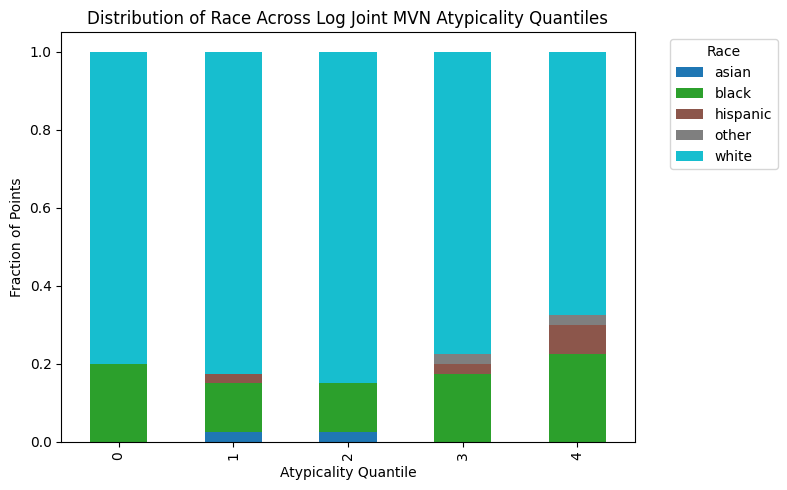

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

num_quantiles = 5
df_test_full['quantile'] = pd.qcut(df_test_full['logjointmvn_score'], num_quantiles, labels=False)
ct = pd.crosstab(df_test_full['quantile'], df_test_full['race'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='tab10', figsize=(8,5))

plt.xlabel('Atypicality Quantile')
plt.ylabel('Fraction of Points')
plt.title('Distribution of Race Across Log Joint MVN Atypicality Quantiles')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


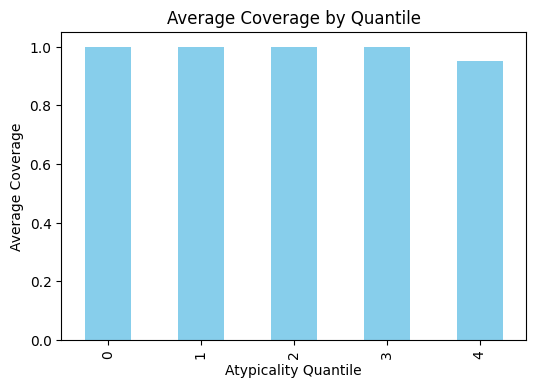

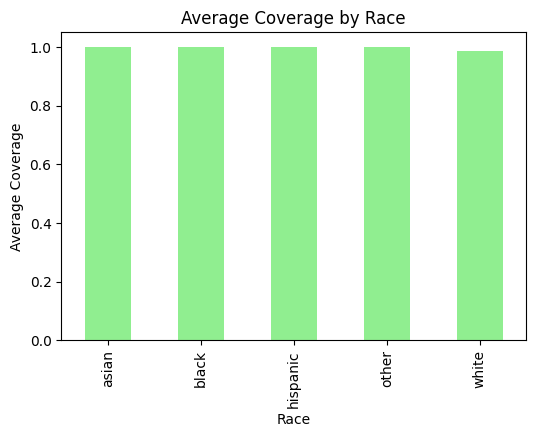

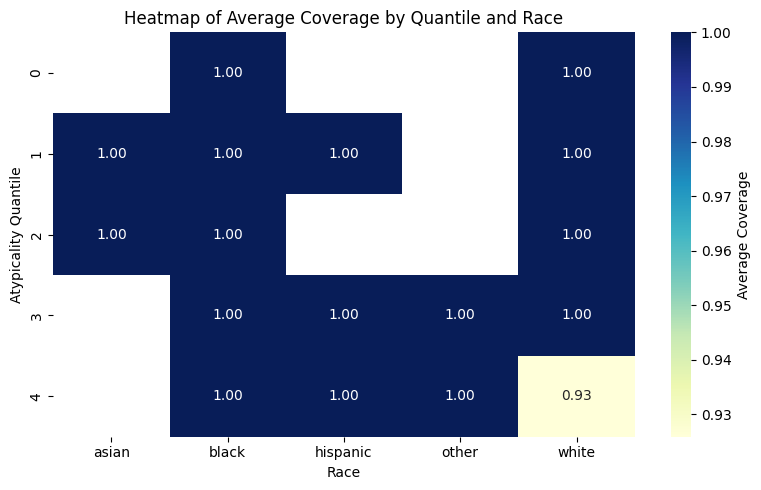

In [23]:
import seaborn as sns
# Avg coverage by quantile
df_test_full.groupby(['quantile'])['covered'].mean().plot(kind='bar', figsize=(6,4), color='skyblue')
plt.xlabel('Atypicality Quantile')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Quantile')
plt.show()

# By race
df_test_full.groupby('race')['covered'].mean().plot(kind='bar', figsize=(6,4), color='lightgreen')
plt.xlabel('Race')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Race')
plt.show()

# By race and quantile
coverage_q_r = df_test_full.groupby(['quantile', 'race'])['covered'].mean().unstack()

plt.figure(figsize=(8,5))
sns.heatmap(coverage_q_r, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Coverage'})

plt.xlabel('Race')
plt.ylabel('Atypicality Quantile')
plt.title('Heatmap of Average Coverage by Quantile and Race')
plt.tight_layout()
plt.show()

/var/folders/r5/dmwpdlqs1wsdz_x7szn5tjym0000gn/T/ipykernel_26067/2026930926.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="race", y="logjointmvn_score", data=df_test_full, palette="Blues")


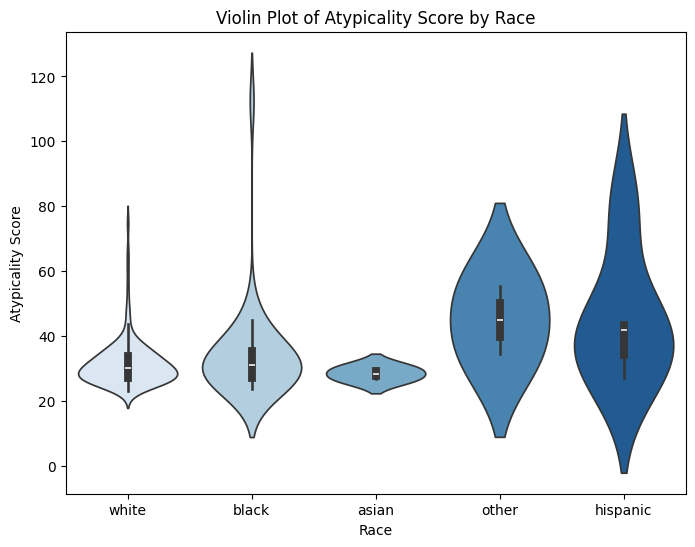

In [25]:
# Create the violin plot
plt.figure(figsize=(8, 6)) # Optional: Adjusts the figure size
sns.violinplot(x="race", y="logjointmvn_score", data=df_test_full, palette="Blues")

# Add titles and labels (optional, using matplotlib's pyplot interface)
plt.title("Violin Plot of Atypicality Score by Race")
plt.xlabel("Race")
plt.ylabel("Atypicality Score")

# Display the plot
plt.show()

# Testing California Housing Dataset

In [ ]:
from data_generation_settings import load_and_split_chd_data
from sklearn.datasets import fetch_california_housing

def split_and_scale_data_race(X, y, test_size, calib_size, random_seed, extra_arrays=None):
    if extra_arrays is None:
        extra_arrays = []

    # First split: train / test
    split_out = train_test_split(
        X, y, *extra_arrays,
        test_size=test_size,
        random_state=random_seed
    )

    X_train, X_test = split_out[0], split_out[1]
    y_train, y_test = split_out[2], split_out[3]

    n_extra = len(extra_arrays)
    extra_train = split_out[4 : 4 + n_extra]
    extra_test  = split_out[4 + n_extra :]

    # Second split: fit / calib (ONLY training extras)
    split_out = train_test_split(
        X_train, y_train, *extra_train,
        test_size=calib_size,
        random_state=random_seed
    )

    X_fit, X_calib = split_out[0], split_out[1]
    y_fit, y_calib = split_out[2], split_out[3]
    extra_fit_calib = split_out[4:]

    # Scale X only
    scaler = StandardScaler()
    X_fit = scaler.fit_transform(X_fit)
    X_calib = scaler.transform(X_calib)
    X_test = scaler.transform(X_test)

    return (
        X_fit, X_calib, X_test,
        y_fit, y_calib, y_test,
        *extra_fit_calib, *extra_test,
        scaler
    )

###
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X['IncQuantile'] = pd.qcut(X['MedInc'], 5, labels=False)

# Log transform columns
cols_to_log = [ 'total_rooms', 'total_bedrooms', 'population', 'households']
cols_to_log = [c for c in cols_to_log if c in X.columns]

# Shift if necessary to avoid log(0) or negatives
for col in cols_to_log:
    min_val = X[col].min()
    if min_val <= 0:
        X[col] = np.log1p(X[col] - min_val + 1)  # shift to >0
    else:
        X[col] = np.log(X[col])

# Sample a subset
sampled_idx = X.sample(n=5000, random_state=1).index
X = X.loc[sampled_idx]
y = y.loc[sampled_idx]

# Split data
inc_quant = X['IncQuantile'].to_numpy()
X.drop(columns=['IncQuantile', 'MedInc'], inplace=True)

feature_names = X.columns.tolist()
X_fit, X_calib, X_test, \
    y_fit, y_calib, y_test, \
        inc_fit, inc_calib, inc_test, scaler = split_and_scale_data_race(X, y, 
                                                                            test_size=0.2, 
                                                                            calib_size=0.2, 
                                                                            random_seed=random_seed, 
                                                                            extra_arrays=[inc_quant])

In [124]:
lacp = fit_conformal_cp_model(X_fit, y_fit, X_calib, y_calib)
y_pred, y_lower, y_upper = lacp.predict(X_test, alpha=0.2)

# Calibration median
calib_scores = compute_atypicality_scores(
X_calib, y_calib, X_fit, y_fit, score_type='logjointmvn_score')
med_score = np.median(calib_scores)

# Test scores
y_for_score = y_test
scores = compute_atypicality_scores(X_test, y_for_score, X_fit, y_fit, score_type='logjointmvn_score')

print("Test!")
print("y_test:", np.shape(y_test))
print("y_pred:", np.shape(y_pred))
print("y_lower:", np.shape(y_lower))
print("y_upper:", np.shape(y_upper))
print("scores:", np.shape(scores))

df = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred[:, 0],
    "y_pred_lower": y_lower,
    "y_pred_upper": y_upper,
    "logjointmvn_score": scores,
    "base_scaling": (scores - med_score) / med_score})

/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/deel/puncc/api/prediction.py:45: SyntaxWarning: invalid escape sequence '\h'
  """Wrapper of a point prediction model :math:`\hat{f}`. Enables to
/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/deel/puncc/api/prediction.py:146: SyntaxWarning: invalid escape sequence '\h'
  on the underlying model :math:`\hat{f}`.
/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/deel/puncc/api/prediction.py:165: SyntaxWarning: invalid escape sequence '\h'
  method of the underlying model :math:`\hat{f}`.
/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/deel/puncc/api/prediction.py:329: SyntaxWarning: invalid escape sequence '\h'
  :math:`(\hat{f_1},\hat{f_2})`.
/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/deel/puncc/api/pred

KeyboardInterrupt: 

In [104]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)
inc_test_s = pd.Series(inc_test, name="IncQuantile")
df_test_full = pd.concat([df.reset_index(drop=True),
                            X_test_df.reset_index(drop=True),
                            inc_test_s.reset_index(drop=True),],
                            axis=1)

df_test_full['covered'] = df_test_full['y_test'].between(
    df_test_full['y_pred_lower'], df_test_full['y_pred_upper'])

In [105]:
df_test_full['IncQuantile'].value_counts()

IncQuantile
0    214
2    202
3    200
4    196
1    188
Name: count, dtype: int64

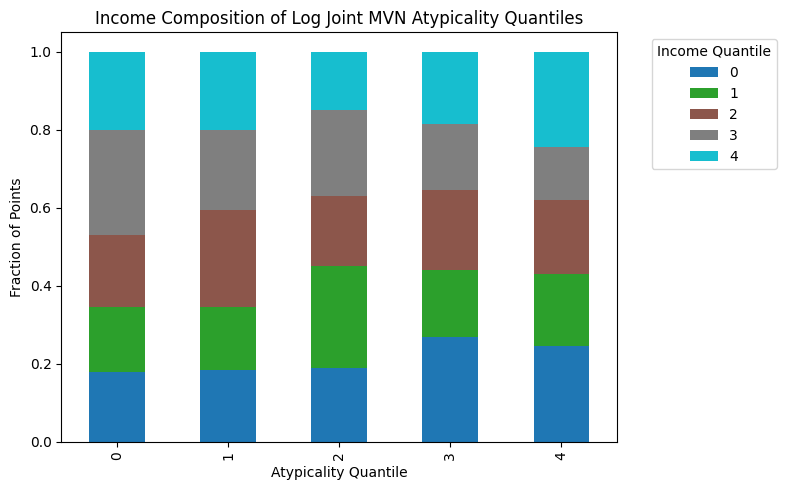

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

num_quantiles = 5
df_test_full['quantile'] = pd.qcut(df_test_full['logjointmvn_score'], num_quantiles, labels=False)
ct = pd.crosstab(df_test_full['quantile'], df_test_full['IncQuantile'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='tab10', figsize=(8,5))

plt.xlabel('Atypicality Quantile')
plt.ylabel('Fraction of Points')
plt.title('Income Composition of Log Joint MVN Atypicality Quantiles')
plt.legend(title='Income Quantile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


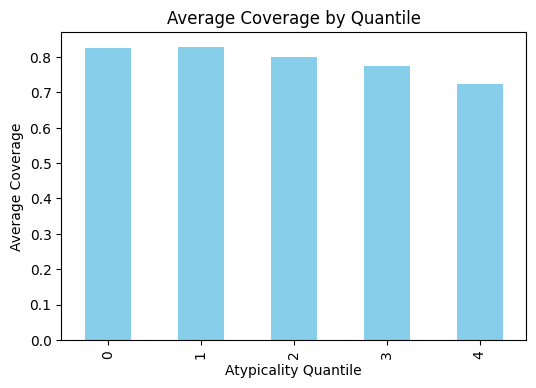

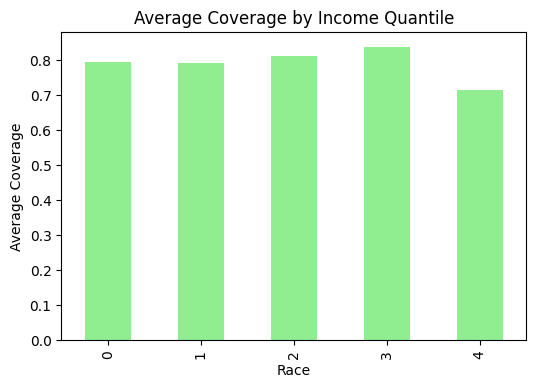

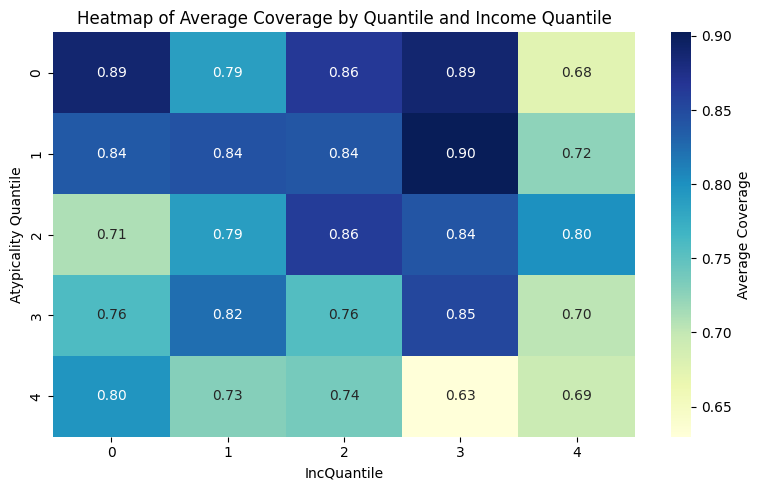

In [107]:
import seaborn as sns
# Avg coverage by quantile
df_test_full.groupby(['quantile'])['covered'].mean().plot(kind='bar', figsize=(6,4), color='skyblue')
plt.xlabel('Atypicality Quantile')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Quantile')
plt.show()

# By race
df_test_full.groupby('IncQuantile')['covered'].mean().plot(kind='bar', figsize=(6,4), color='lightgreen')
plt.xlabel('Race')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Income Quantile')
plt.show()

# By race and quantile
coverage_q_r = df_test_full.groupby(['quantile', 'IncQuantile'])['covered'].mean().unstack()

plt.figure(figsize=(8,5))
sns.heatmap(coverage_q_r, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Coverage'})

plt.xlabel('IncQuantile')
plt.ylabel('Atypicality Quantile')
plt.title('Heatmap of Average Coverage by Quantile and Income Quantile')
plt.tight_layout()
plt.show()

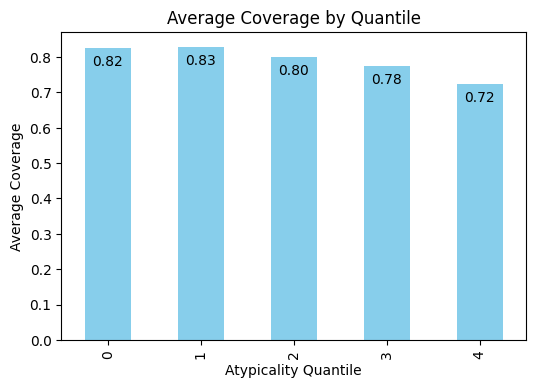

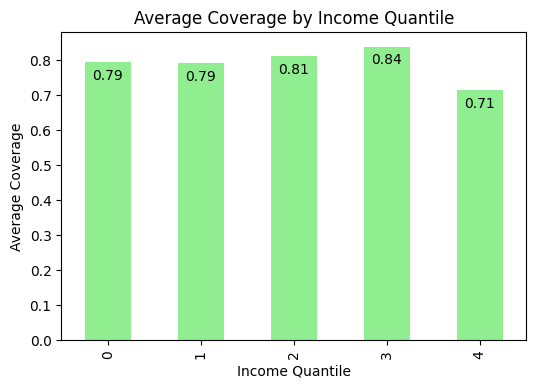

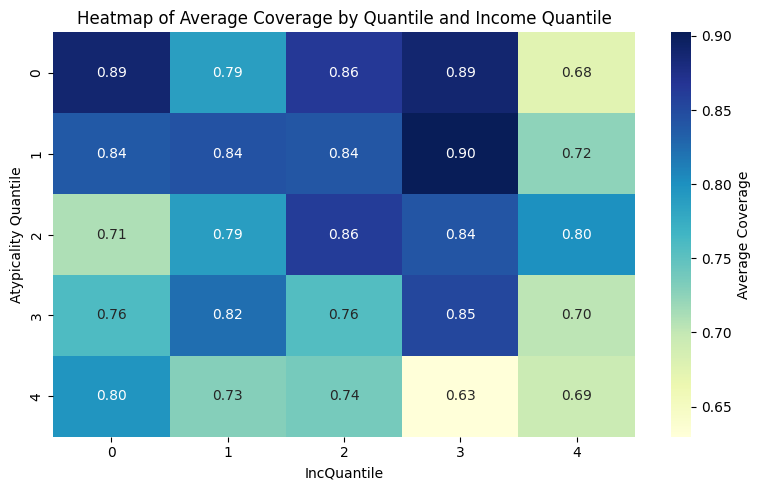

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Avg coverage by quantile ---
ax = df_test_full.groupby('quantile')['covered'].mean().plot(
    kind='bar', figsize=(6,4), color='skyblue'
)
plt.xlabel('Atypicality Quantile')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Quantile')

# Add numbers on top of bars
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,  # x position
        p.get_height() - 0.05,       # y position slightly above bar
        f"{p.get_height():.2f}",      # format number
        ha='center', fontsize=10
    )
plt.show()

# --- By Income Quantile ---
ax = df_test_full.groupby('IncQuantile')['covered'].mean().plot(
    kind='bar', figsize=(6,4), color='lightgreen'
)
plt.xlabel('Income Quantile')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Income Quantile')

# Add numbers on top of bars
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height() - 0.05,
        f"{p.get_height():.2f}",
        ha='center', fontsize=10
    )
plt.show()

# --- Heatmap by quantile and income quantile ---
coverage_q_r = df_test_full.groupby(['quantile', 'IncQuantile'])['covered'].mean().unstack()

plt.figure(figsize=(8,5))
sns.heatmap(coverage_q_r, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Coverage'})
plt.xlabel('IncQuantile')
plt.ylabel('Atypicality Quantile')
plt.title('Heatmap of Average Coverage by Quantile and Income Quantile')
plt.tight_layout()
plt.show()


/var/folders/r5/dmwpdlqs1wsdz_x7szn5tjym0000gn/T/ipykernel_26067/2465950714.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="IncQuantile", y="logjointmvn_score", data=df_test_full, palette="Blues")


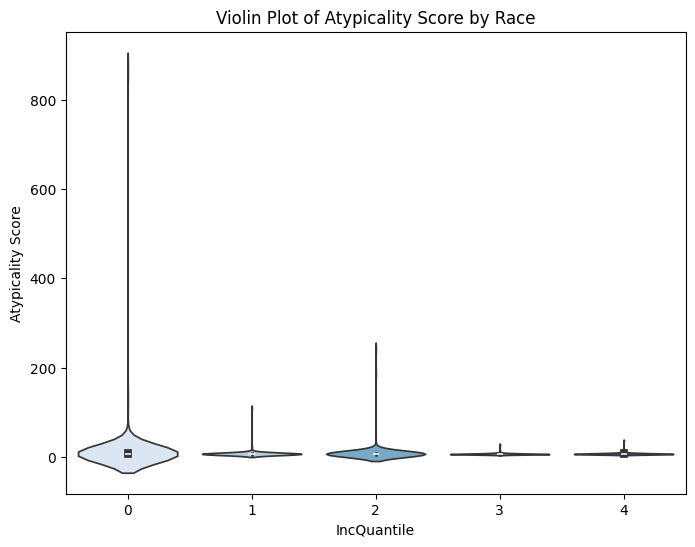

In [109]:
# Create the violin plot
plt.figure(figsize=(8, 6)) # Optional: Adjusts the figure size
sns.violinplot(x="IncQuantile", y="logjointmvn_score", data=df_test_full, palette="Blues")

# Add titles and labels (optional, using matplotlib's pyplot interface)
plt.title("Violin Plot of Atypicality Score by Race")
plt.xlabel("IncQuantile")
plt.ylabel("Atypicality Score")

# Display the plot
plt.show()

Implement AAPI correction

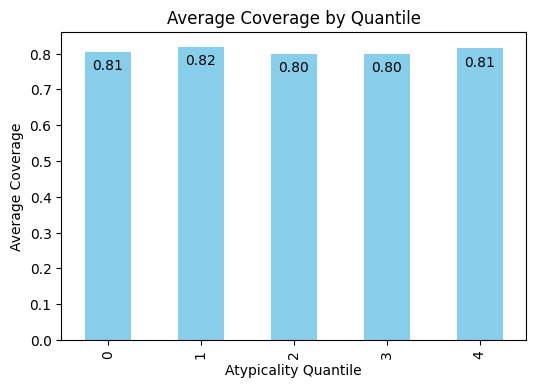

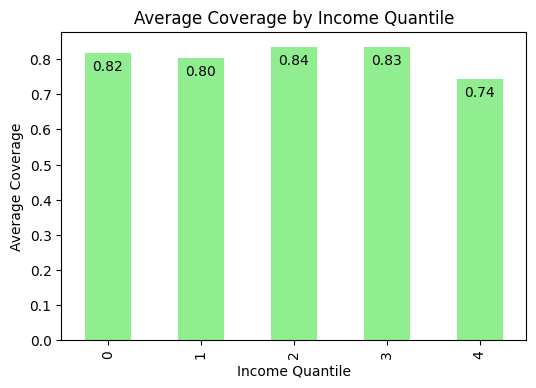

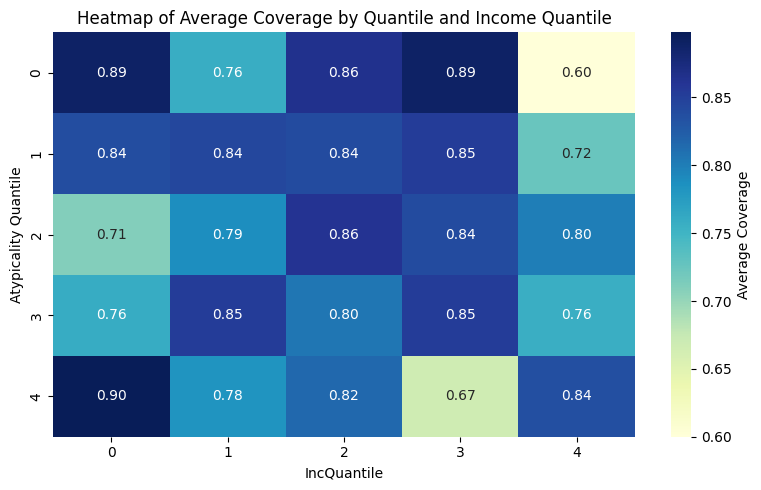

In [113]:
lam = 0.5
scaling = 1 + lam * df_test_full["base_scaling"]
df_test_full['lam_lower_col'] = df_test_full["y_pred"] - scaling * (df_test_full["y_pred"] - df_test_full["y_pred_lower"])
df_test_full['lam_upper_col'] = df_test_full["y_pred"] + scaling * (df_test_full["y_pred_upper"] - df_test_full["y_pred"])
df_test_full['covered_lam'] = df_test_full['y_test'].between(
    df_test_full['lam_lower_col'], df_test_full['lam_upper_col'])


# --- Avg coverage by quantile ---
ax = df_test_full.groupby('quantile')['covered_lam'].mean().plot(
    kind='bar', figsize=(6,4), color='skyblue'
)
plt.xlabel('Atypicality Quantile')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Quantile')

# Add numbers on top of bars
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,  # x position
        p.get_height() - 0.05,       # y position slightly above bar
        f"{p.get_height():.2f}",      # format number
        ha='center', fontsize=10
    )
plt.show()

# --- By Income Quantile ---
ax = df_test_full.groupby('IncQuantile')['covered_lam'].mean().plot(
    kind='bar', figsize=(6,4), color='lightgreen'
)
plt.xlabel('Income Quantile')
plt.ylabel('Average Coverage')
plt.title('Average Coverage by Income Quantile')

# Add numbers on top of bars
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height() - 0.05,
        f"{p.get_height():.2f}",
        ha='center', fontsize=10
    )
plt.show()

# --- Heatmap by quantile and income quantile ---
coverage_q_r = df_test_full.groupby(['quantile', 'IncQuantile'])['covered_lam'].mean().unstack()

plt.figure(figsize=(8,5))
sns.heatmap(coverage_q_r, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Coverage'})
plt.xlabel('IncQuantile')
plt.ylabel('Atypicality Quantile')
plt.title('Heatmap of Average Coverage by Quantile and Income Quantile')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Income Distribution'}, ylabel='Frequency'>

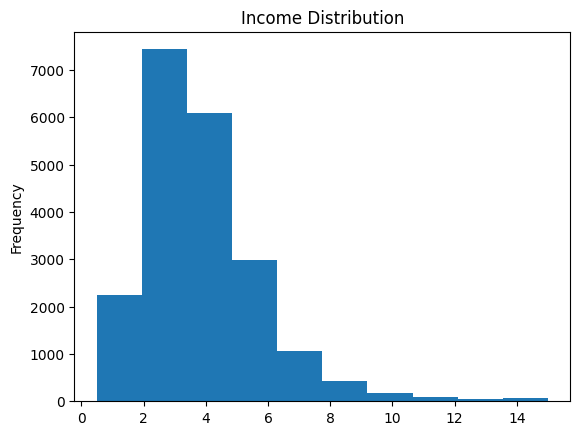

In [154]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X['MedInc'].plot(kind='hist', title="Income Distribution")

# Trying to implement MIMIC with evaluate_lambda_..

In [ ]:
import pandas as pd
import numpy as np
import pickle
from data_generation_settings import split_and_scale_data_attr

# Took 347min to run with 10k samples and 5 splits
def load_and_split_mimic_data(random_seed, test_size=0.2, calib_size=0.2, n_samples=50):
    # Primary Admissions information
    df = pd.read_csv(r"../data/MIMIC-IV-v1.0/admissions.csv")
    df_pat = pd.read_csv(r"../data/MIMIC-IV-v1.0/patients.csv")
    df_diagcode = pd.read_csv(r"../data/MIMIC-IV-v1.0/diagnoses_icd.csv")
    df_icu = pd.read_csv(r"../data/MIMIC-IV-v1.0/icustays.csv")

    print('Dataset has {} unique admission events.'.format(df['hadm_id'].nunique()))
    print('Dataset has {} unique patients.'.format(df['subject_id'].nunique()))

    # Merge patient demographics including gender and race
    df = df.merge(df_pat[['subject_id', 'gender', 'anchor_age']], 
                on='subject_id', how='left')

    # Calculate Length of Stay
    df['ADMITTIME'] = pd.to_datetime(df['admittime'])
    df['DISCHTIME'] = pd.to_datetime(df['dischtime'])
    df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

    # Drop rows with negative or zero LOS
    df = df[df['LOS'] > 0]

    # Filter LOS < 40 days to reduce skewness
    df = df[df['LOS'] < 40]

    print(f"LOS Statistics:\nMean: {df['LOS'].mean():.2f} days")
    print(f"Median: {df['LOS'].median():.2f} days")
    print(f"Min: {df['LOS'].min():.2f} days")
    print(f"Max: {df['LOS'].max():.2f} days")

    # Standardize ethnicity categories
    df['ethnicity'] = df['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN')
    df['ethnicity'] = df['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE')
    df['ethnicity'] = df['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO')
    df['ethnicity'] = df['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN')
    df['ethnicity'] = df['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER', 'UNKNOWN'], 
                        value='OTHER/UNKNOWN')

    # Keep only top 5 categories
    top_ethnicities = df['ethnicity'].value_counts().nlargest(5).index.tolist()
    df.loc[~df['ethnicity'].isin(top_ethnicities), 'ethnicity'] = 'OTHER/UNKNOWN'

    print("\nEthnicity Distribution:")
    print(df['ethnicity'].value_counts())

    # Process other demographics
    # Marital status
    df['marital_status'] = df['marital_status'].fillna('UNKNOWN')

    # Deceased indicator
    df['DECEASED'] = df['deathtime'].notnull().astype(int)

    print(f"\n{df['DECEASED'].sum()} of {df['subject_id'].nunique()} patients died")

    # Process Diagnosis Codes
    # Filter ICD-9 codes and recode
    df_diagcode['recode'] = df_diagcode['icd_code'][df_diagcode['icd_version'] == 9]
    mask = df_diagcode['recode'].str.contains("[a-zA-Z]", na=False)
    df_diagcode['recode'] = df_diagcode['recode'][~mask]
    df_diagcode['recode'] = df_diagcode['recode'].fillna('999')
    df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
    df_diagcode['recode'] = df_diagcode['recode'].astype(int)

    # ICD-9 Main Category ranges
    icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), 
                (320, 390), (390, 460), (460, 520), (520, 580), (580, 630), 
                (630, 680), (680, 710), (710, 740), (740, 760), (760, 780), 
                (780, 800), (800, 1000), (1000, 2000)]

    diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
                4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
                8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
                12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
                16: 'injury', 17: 'misc'}

    for num, cat_range in enumerate(icd9_ranges):
        df_diagcode['recode'] = np.where(
            df_diagcode['recode'].between(cat_range[0], cat_range[1]), 
            num, df_diagcode['recode'])

    df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

    # Create admission-diagnosis matrix
    hadm_list = df_diagcode.groupby('hadm_id')['cat'].apply(list).reset_index()
    hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
    hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

    # Merge with main dataframe
    df = df.merge(hadm_item, how='inner', on='hadm_id')

    # Process ICU Information
    df_icu['first_careunit'] = df_icu['first_careunit'].replace({
        'Coronary Care Unit (CCU)': 'ICU',
        'Neuro Stepdown': 'NICU',
        'Neuro Intermediate': 'NICU',
        'Cardiac Vascular Intensive Care Unit (CVICU)': "ICU",
        'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'ICU',
        'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'ICU',
        'Medical Intensive Care Unit (MICU)': 'ICU',
        'Surgical Intensive Care Unit (SICU)': 'ICU',
        'Trauma SICU (TSICU)': 'ICU'})

    df_icu['cat'] = df_icu['first_careunit']
    icu_list = df_icu.groupby('hadm_id')['cat'].apply(list).reset_index()

    # Create admission-ICU matrix
    icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
    icu_item[icu_item >= 1] = 1
    icu_item = icu_item.join(icu_list['hadm_id'], how="outer")

    # Merge with main dataframe
    df = df.merge(icu_item, how='outer', on='hadm_id')
    df['ICU'] = df['ICU'].fillna(value=0)
    df['NICU'] = df['NICU'].fillna(value=0)

    # Drop unnecessary columns
    columns_to_drop = ['admission_location', 'subject_id', 'hadm_id', 'ADMITTIME', 
                    'admittime', 'DISCHTIME', 'dischtime', 'discharge_location', 
                    'language', 'DECEASED', 'deathtime', 'edregtime', 'edouttime',
                    'hospital_expire_flag']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], 
            inplace=True, errors='ignore')

    # Drop rows with NaNs in features or target
    df = df.dropna().copy()

    # Save ethnicity
    ethnicity = df['ethnicity']
    df.drop(columns=['ethnicity'], inplace=True)

    # One-hot encode categorical variables
    categorical_cols = ['admission_type', 'insurance', 'marital_status', 
                    'gender']
    df_encoded = pd.get_dummies(df.drop(['LOS'], axis=1), 
                                columns=categorical_cols, 
                                drop_first=True)
    # Save features and target variables
    X = df_encoded
    y = df['LOS']

    # Sample a subset
    sampled_idx = X.sample(n=n_samples, random_state=random_seed).index
    X = X.loc[sampled_idx].values
    y = y.loc[sampled_idx].values
    ethnicity = ethnicity.loc[sampled_idx].values

    X_fit, X_calib, X_test, \
        y_fit, y_calib, y_test, \
            ethfit, eth_calib, eth_test, scaler = split_and_scale_data_attr(X, y, 
                                                                                test_size=test_size, 
                                                                                calib_size=calib_size, 
                                                                                random_seed=random_seed, 
                                                                                extra_arrays=[ethnicity])
    return X_fit, X_calib, X_test, y_fit, y_calib, y_test, ethfit, eth_calib, eth_test, scaler

atypicality_settings = [('logjointmvn_score', 0)]
coverage_by_quantile_lambda, df_mimic = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_mimic_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=10000, # Number of samples is ignored; real dataset is of fixed size
                                        n_splits=5, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        extra_attribute=True,
                                        silent=True)

# Save results to a pickle file
with open("../intermediate/mimic-n10k/mimic_n10k_dfs_conformal_trueatypicality.pkl", "wb") as f:
    pickle.dump(df_mimic, f)

Dataset has 523740 unique admission events.
Dataset has 256878 unique patients.
LOS Statistics:
Mean: 4.13 days
Median: 2.65 days
Min: 0.00 days
Max: 40.00 days

Ethnicity Distribution:
ethnicity
WHITE                     335318
BLACK/AFRICAN AMERICAN     79780
OTHER/UNKNOWN              50826
HISPANIC/LATINO            29625
ASIAN                      24281
Name: count, dtype: int64

8943 of 255106 patients died
Training model from scratch...
Model trained and weights saved to ../intermediate/model_4ec1158cbed2fa36f6948cbc27dde957.weights.pt
Defined GP!


/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Log Marginal Likelihood: -4098030382181.5103
Trained and saved new GP model to ../intermediate/gp_model_4ec1158cbed2fa36f6948cbc27dde957.pkl
Manually setting is trained to true:


1600it [10:53,  2.45it/s]
2000it [09:49,  3.39it/s]


Dataset has 523740 unique admission events.
Dataset has 256878 unique patients.
LOS Statistics:
Mean: 4.13 days
Median: 2.65 days
Min: 0.00 days
Max: 40.00 days

Ethnicity Distribution:
ethnicity
WHITE                     335318
BLACK/AFRICAN AMERICAN     79780
OTHER/UNKNOWN              50826
HISPANIC/LATINO            29625
ASIAN                      24281
Name: count, dtype: int64

8943 of 255106 patients died
Training model from scratch...
Model trained and weights saved to ../intermediate/model_e7e856735cdff7bb7c75d9aaced4a127.weights.pt
Defined GP!


/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GP Log Marginal Likelihood: -2134612044587.374
Trained and saved new GP model to ../intermediate/gp_model_e7e856735cdff7bb7c75d9aaced4a127.pkl
Manually setting is trained to true:


1600it [05:07,  5.20it/s]
2000it [06:22,  5.23it/s]


Dataset has 523740 unique admission events.
Dataset has 256878 unique patients.
LOS Statistics:
Mean: 4.13 days
Median: 2.65 days
Min: 0.00 days
Max: 40.00 days

Ethnicity Distribution:
ethnicity
WHITE                     335318
BLACK/AFRICAN AMERICAN     79780
OTHER/UNKNOWN              50826
HISPANIC/LATINO            29625
ASIAN                      24281
Name: count, dtype: int64

8943 of 255106 patients died
Training model from scratch...
Model trained and weights saved to ../intermediate/model_92066919a852b522dcf27237ed0047db.weights.pt
Defined GP!


/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Log Marginal Likelihood: -2040278472251.1365
Trained and saved new GP model to ../intermediate/gp_model_92066919a852b522dcf27237ed0047db.pkl
Manually setting is trained to true:


1600it [05:02,  5.30it/s]
2000it [06:18,  5.29it/s]


Dataset has 523740 unique admission events.
Dataset has 256878 unique patients.
LOS Statistics:
Mean: 4.13 days
Median: 2.65 days
Min: 0.00 days
Max: 40.00 days

Ethnicity Distribution:
ethnicity
WHITE                     335318
BLACK/AFRICAN AMERICAN     79780
OTHER/UNKNOWN              50826
HISPANIC/LATINO            29625
ASIAN                      24281
Name: count, dtype: int64

8943 of 255106 patients died
Training model from scratch...
Model trained and weights saved to ../intermediate/model_64f256d94296b3d29edf3b7bda51e4fa.weights.pt
Defined GP!


/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Log Marginal Likelihood: -2706550915542.3003
Trained and saved new GP model to ../intermediate/gp_model_64f256d94296b3d29edf3b7bda51e4fa.pkl
Manually setting is trained to true:


1600it [05:02,  5.29it/s]
2000it [06:16,  5.31it/s]


Dataset has 523740 unique admission events.
Dataset has 256878 unique patients.
LOS Statistics:
Mean: 4.13 days
Median: 2.65 days
Min: 0.00 days
Max: 40.00 days

Ethnicity Distribution:
ethnicity
WHITE                     335318
BLACK/AFRICAN AMERICAN     79780
OTHER/UNKNOWN              50826
HISPANIC/LATINO            29625
ASIAN                      24281
Name: count, dtype: int64

8943 of 255106 patients died
Training model from scratch...
Model trained and weights saved to ../intermediate/model_6410ab71e848ce31dc7831115b7a53e3.weights.pt
Defined GP!


/Users/audreyxychang/Documents/GitHub/extending-atypicality/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GP Log Marginal Likelihood: -1832756435619.0454
Trained and saved new GP model to ../intermediate/gp_model_6410ab71e848ce31dc7831115b7a53e3.pkl
Manually setting is trained to true:


1600it [05:04,  5.26it/s]
2000it [06:17,  5.29it/s]


{'logjointmvn_score_lam0': [        y_test    y_pred  y_pred_lower  y_pred_upper  logjointmvn_score  \
  0     2.158333  3.028736      0.449475      5.607998          33.094225   
  1     9.923611  5.191768      1.375676      9.007859          85.507326   
  2     0.572222  0.830679     -2.985412      4.646771          46.091046   
  3     0.950000  2.360077     -1.456014      6.176169          40.549115   
  4     8.865972  5.838128      2.022036      9.654219          40.470691   
  ...        ...       ...           ...           ...                ...   
  1995  5.125000  3.559497     -0.256594      7.375589          43.277591   
  1996  1.059722  4.158611      0.342519      7.974702          42.064952   
  1997  2.529861  0.617530     -3.198562      4.433622          43.233344   
  1998  0.745139  0.691102     -3.124989      4.507194          45.406161   
  1999  3.678472  1.594183     -2.221909      5.410274          45.250766   
  
        aapi_logjointmvn_score_lower_lam0  aapi

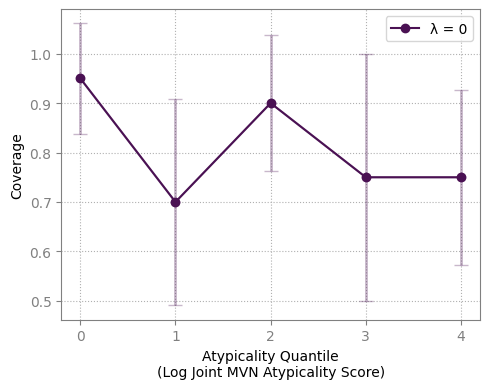

In [ ]:
# Plot result for a specific atypicality score
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

Asking why there are 25 dataframes

In [ ]:
# Re-load pickled file
with open("../intermediate/mimic-n10k/mimic_n10k_dfs.pkl", "rb") as f:
    mimic_dfs = pickle.load(f)

/var/folders/r5/dmwpdlqs1wsdz_x7szn5tjym0000gn/T/ipykernel_62218/3275751215.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(coverage_mean.index, rotation=0, ha='center')


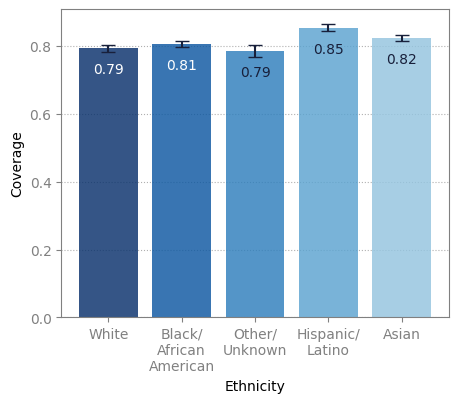

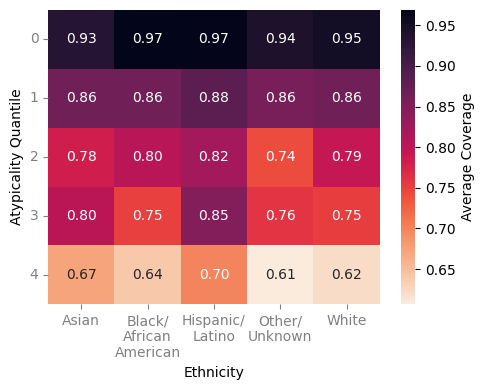

In [ ]:
def avg_coverage_by_attr_witherror(dfs, attribute="attr", attribute_name="Ethnicity", ethnicity_mapping=None, desired_order=None):
    # Compute coverage for each dataframe if not already present
    for df in dfs:
        df['covered'] = ((df['y_test'] >= df['y_pred_lower']) & 
                        (df['y_test'] <= df['y_pred_upper'])).astype(int)
    
    # Stack coverage across splits for each group
    coverage_by_group = pd.concat([df.groupby(attribute)['covered'].mean().rename(f'split_{i}') 
        for i, df in enumerate(dfs)], axis=1)
    
    # Compute mean and standard error
    coverage_mean = coverage_by_group.mean(axis=1)
    coverage_se = coverage_by_group.std(axis=1, ddof=1) / np.sqrt(len(dfs))

    # Apply ethnicity mapping if provided
    if ethnicity_mapping is not None:
        coverage_mean.index = coverage_mean.index.map(lambda x: ethnicity_mapping.get(x, x))
        coverage_se.index = coverage_se.index.map(lambda x: ethnicity_mapping.get(x, x))
    
    # Reorder according to desired_order if provided
    if desired_order is not None:
        coverage_mean = coverage_mean.reindex(desired_order)
        coverage_se = coverage_se.reindex(desired_order)

    fig, ax = plt.subplots(figsize=(5,4))

    # Create shades of blue for bars
    n_bars = len(coverage_mean)
    colors = plt.cm.Blues(np.linspace(1, 0.4, n_bars))

    # Bar positions
    x_pos = np.arange(len(coverage_mean))

    # Bar plot with error bars
    ax.bar(
        x_pos,
        coverage_mean.values,
        yerr=coverage_se.values,
        capsize=5,
        color=colors,
        width=0.8,
        alpha=0.82,
        ecolor='#18203B')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(coverage_mean.index, rotation=0, ha='center')
    ax.set_xlabel(attribute_name)
    ax.set_ylabel('Coverage')

    # Add numbers on top of bars
    for i, (mean, se) in enumerate(zip(coverage_mean.values, coverage_se.values)):
        # Set color: first 3 bars white, rest #18203B
        text_color = 'white' if i < 2 else '#18203B'
        
        ax.text(
            i,
            mean - 0.075,
            f"{mean:.2f}",
            ha='center',
            fontsize=10,
            color=text_color
        )

    # Grid and style
    ax.set_axisbelow(True)
    ax.grid(True, axis="y", which="major", linestyle='dotted')
    ax.tick_params(axis='both', colors='grey')
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')

    plt.show()
def heatmap_by_quantile_attribute(dfs, attribute="attr", atyp_col='logjointmvn_score', num_quantiles=5, attribute_name="Ethnicity", ethnicity_mapping=None):
    # Ensure 'covered' column exists for each split
    for df in dfs:
        df['covered'] = ((df['y_test'] >= df['y_pred_lower']) & 
                         (df['y_test'] <= df['y_pred_upper'])).astype(int)
        df['quantile'] = pd.qcut(df[atyp_col], num_quantiles, labels=False)

    # Compute coverage by quantile and attribute for each split
    coverage_splits = []
    for df in dfs:
        coverage_q_attr = df.groupby(['quantile', attribute])['covered'].mean().unstack()
        coverage_splits.append(coverage_q_attr)
    
    # Take mean across splits
    coverage_mean = pd.concat(coverage_splits).groupby(level=0).mean()
    
    # Apply ethnicity mapping if provided
    if ethnicity_mapping is not None:
        coverage_mean.columns = [ethnicity_mapping.get(col, col) for col in coverage_mean.columns]
    
    # Plot heatmap
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(coverage_mean, annot=True, fmt=".2f", cmap="rocket_r", cbar_kws={'label': 'Average Coverage'})
    
    plt.xticks(rotation=0)
    plt.xlabel(attribute_name)
    plt.ylabel('Atypicality Quantile')
    plt.yticks(rotation=0)
    
    # Style
    ax.tick_params(axis='both', colors='grey')
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
    
    plt.tight_layout()
    plt.show()

ethnicity_map = {
    "WHITE": "White",
    "BLACK/AFRICAN AMERICAN": "Black/\nAfrican\nAmerican",
    "HISPANIC/LATINO": "Hispanic/\nLatino",
    "ASIAN": "Asian",
    "OTHER/UNKNOWN": "Other/\nUnknown"}

desired_order = ["White", "Black/\nAfrican\nAmerican", "Other/\nUnknown", "Hispanic/\nLatino", "Asian"]

avg_coverage_by_attr_witherror(mimic_dfs, 
                               attribute_name="Ethnicity", 
                               ethnicity_mapping=ethnicity_map,
                               desired_order=desired_order)
heatmap_by_quantile_attribute(mimic_dfs, attribute="attr", attribute_name="Ethnicity", ethnicity_mapping=ethnicity_map)

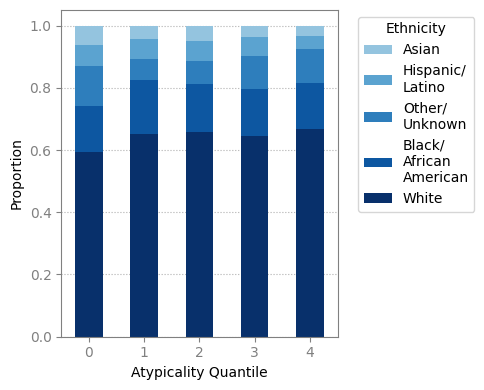

In [ ]:
def plot_mean_demographic_composition(
    dfs,
    score_col="logjointmvn_score",
    attr_col="attr",
    ethnicity_map=None,
    desired_order=None,
    num_quantiles=5):
    ct_list = []

    for df in dfs:
        df = df.copy()

        # Map ethnicity labels
        if ethnicity_map is not None:
            df[attr_col] = df[attr_col].map(ethnicity_map)

        # Assign quantiles per split
        df["quantile"] = pd.qcut(df[score_col], num_quantiles, labels=False)

        # Normalized crosstab
        ct = pd.crosstab(df["quantile"], df[attr_col], normalize="index")
        ct_list.append(ct)

    # Align columns across splits
    all_cols = sorted(set(col for ct in ct_list for col in ct.columns))
    ct_aligned = [ct.reindex(columns=all_cols, fill_value=0) for ct in ct_list]

    # Mean composition across splits
    mean_ct = pd.concat(ct_aligned).groupby(level=0).mean()

    # Enforce desired column order
    if desired_order is not None:
        mean_ct = mean_ct.reindex(columns=desired_order)

    # Create shades of blue (darkest first)
    n_groups = mean_ct.shape[1]
    colors = plt.cm.Blues(np.linspace(1, 0.4, n_groups))

    # Plot
    ax = mean_ct.plot(
        kind="bar",
        stacked=True,
        figsize=(5, 4),
        color=colors)

    # Styling
    ax.set_axisbelow(True)
    ax.grid(True, axis="y", which="major", linestyle="dotted")
    ax.tick_params(axis="both", colors="grey")
    for spine in ax.spines.values():
        spine.set_edgecolor("grey")

    plt.xlabel("Atypicality Quantile")
    plt.ylabel("Proportion")
    plt.xticks(rotation=0)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1],
        labels[::-1],
        title="Ethnicity",
        bbox_to_anchor=(1.05, 1),
        loc="upper left")
    plt.tight_layout()
    plt.show()

plot_mean_demographic_composition(
    unique_mimic_dfs,
    ethnicity_map=ethnicity_map,
    desired_order=desired_order,
    num_quantiles=5)

# Trying to implement CHD data with evaluate_lambda

In [324]:
import pandas as pd
import numpy as np
import pickle
from data_generation_settings import split_and_scale_data_attr
from sklearn.datasets import fetch_california_housing

def load_and_split_chd_data(random_seed, test_size=0.2, calib_size=0.2, n_samples=50):
    """
    The CHD dataset is 20640 total data points, which means n_samples cannot exceed 20640. 
    """
    X, y = fetch_california_housing(return_X_y=True, as_frame=True)
    X['IncQuantile'] = pd.qcut(X['MedInc'], 5, labels=False)

    # Shift if necessary to avoid log(0) or negatives
    for col in cols_to_log:
        min_val = X[col].min()
        if min_val <= 0:
            X[col] = np.log1p(X[col] - min_val + 1)  # shift to >0
        else:
            X[col] = np.log(X[col])

    # Split data
    inc_quant = X['IncQuantile']
    X.drop(columns=['IncQuantile', 'MedInc'], inplace=True)

    # Sample a subset
    sampled_idx = X.sample(n=n_samples, random_state=1).index
    X = X.loc[sampled_idx].values
    y = y.loc[sampled_idx].values
    inc_quant = inc_quant.loc[sampled_idx].values

    X_fit, X_calib, X_test, \
        y_fit, y_calib, y_test, \
            inc_fit, inc_calib, inc_test, scaler = split_and_scale_data_attr(X, y, 
                                                                                test_size=0.2, 
                                                                                calib_size=0.2, 
                                                                                random_seed=random_seed, 
                                                                                extra_arrays=[inc_quant])

    return X_fit, X_calib, X_test, y_fit, y_calib, y_test, inc_fit, inc_calib, inc_test, scaler

atypicality_settings = [('logjointmvn_score', 0)]

coverage_by_quantile_lambda, df_chd = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_chd_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=1000,
                                        n_splits=2, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        extra_attribute=True,
                                        silent=True)

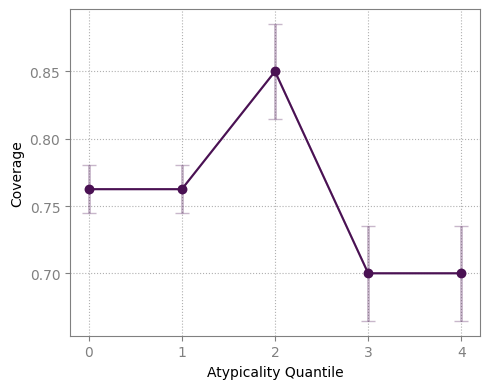

/var/folders/r5/dmwpdlqs1wsdz_x7szn5tjym0000gn/T/ipykernel_62218/3275751215.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(coverage_mean.index, rotation=0, ha='center')


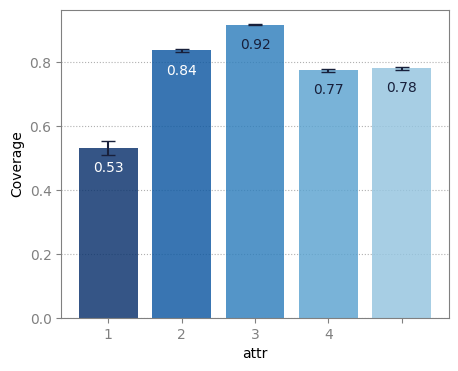

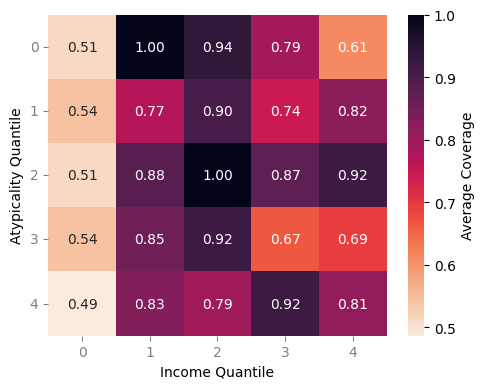

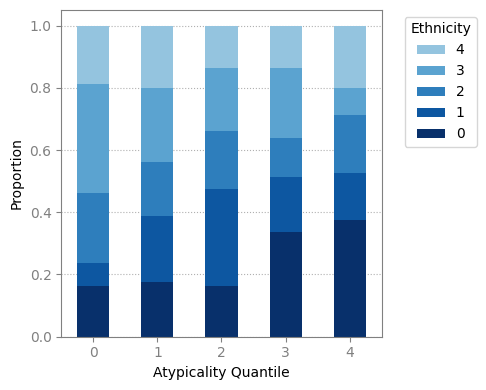

In [327]:
# Quantiles correspond to the bins: 4999-23523, 23523-31406, 31406-39670, 39670-51097, 51097-15000

plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=False)
avg_coverage_by_attr_witherror(df_chd['logjointmvn_score_lam0'], attribute_name="attr")
heatmap_by_quantile_attribute(df_chd['logjointmvn_score_lam0'], attribute="attr", attribute_name="Income Quantile")
plot_mean_demographic_composition(df_chd['logjointmvn_score_lam0'], num_quantiles=5)

In [ ]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
max(X['MedInc']) # Range of X: 0.5 - 15

15.0001

In [314]:
# Load data
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Compute quantiles and get bin edges
X['IncQuantile'], bins = pd.qcut(X['MedInc'], 5, labels=False, retbins=True)

print("Quantile bin edges:", bins)

Quantile bin edges: [ 0.4999   2.3523   3.1406   3.96694  5.10972 15.0001 ]
